In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz
import sys

In [2]:
def inv_tridiagonal_mixed(rhs, N, dx, boundary_conditions, deriv_coef = (0, 0), grid = ''):
    """
    A function that implements an algorithm for inverting a tridiagonal matrix L = tridiag(a, b, c)
    and calculating the solution of the linear problem:
    
    Lu = dx**2*f + b
    
    The algorithm is faster (O(N)) and more accurate than a generic matrix inversion (O(N^2)). 
    It is written following the guidelines of: Richard Fitzpatrick, Computational Physics 
    
    input
    
    rhs: Vector of length N+1. The right-hand side of the equation above
    N: Integer. The number of grid points
    dx: Array of length N+2. The size of the grid points. It can be non-uniform (dx[i] != dx[i-1]).
    boundaty_conditions: A tuple of the form (B1_l, B2_l, B3_l, B1_r, B2_r, B3_r). The parametres for the 
                         Robin boundary conditions
    deriv_coef: Tuple of the form (D1, D2). Coefficients of the terms u', u respectively, 
                                            if they are present in the equation. Default is (0,0)
                                            
    output
    
    u: Vector of length N+2. The solution of the problem including the boundaries.
    """
    
    #-------------------------------------------------------
    
    #read the arguments
    
    dxplus = dx[:N+1]                                          #The step size of the grid. 
    dxminus = np.roll(dxplus, 1)                               #dxplus = dx[i] = x[i+1] - x[i],
                                                               #dxminus = dx[i-1] = x[i] - x[i-1]
        
    B1_l, B2_l, B3_l, B1_r, B2_r, B3_r = boundary_conditions   #Boundary condition parameters of the form 
                                                               #B1_l*u(x_l) + B2_l*u'(x_l) = B3_l and 
                                                               #B1_r*u(x_r) + B2_r*u'(x_r) = B3_r
    
    
        

    
    D1, D2 = deriv_coef                                 #Coefficients of u' and u if present in the equation
    
    #initialise vectors that will be used for reversing the tridiagonal matrix and expressing the solution.
    
    u = np.zeros(N+2)                                   #The solution vector
    
    z = np.zeros(N)                                     #Vectors in terms of which the solution is expressed
    y = np.zeros(N)
    
    a = (2 - D1*dxplus)/(dxminus*(dxplus+dxminus))      #Vectors that compose the tridiagonal matrix
    a[1] = 0.
    if B2_r != 0 and grid == 'uniform':
        a[N] -= B2_r/(2*dx[1]*B1_r+3*B2_r)
    
    b = D2 - (2 + D1*(dxminus - dxplus))/(dxminus*dxplus)
    
    if (B2_r != 0 or B2_l != 0) and grid == 'uniform':
        b[1] += 2*B2_l/(B1_l*dx[1] + B2_l/2)              
        b[N] += 2*B2_r/(B1_r*dx[1] + 3/2*B2_r)
    
    c = (2 + D1*dxminus)/(dxplus*(dxplus+dxminus))
    if B2_l != 0 and grid == 'uniform':
        c[1] -= 3*B2_l/(2*dx[1]*B1_l + B2_l)
    c[N] = 0.
    
    #-------------------------------------------------------

    #Scanning upwards to find the values of the z,y vectors

    z[N-1] = -a[N]/b[N]
    y[N-1] = rhs[N]/b[N]

    for i in range(N-2, 0, -1):

        z[i] = -a[i+1]/(b[i+1] + z[i+1]*c[i+1])
        y[i] = (rhs[i+1] - c[i+1]*y[i+1])/(b[i+1] + z[i+1]*c[i+1])

    z[0] = 0.
    y[0] = (rhs[1] - c[1]*y[1])/(b[1] + z[1]*c[1])
    #scanning downward to find the solution u
    
    u[1] = y[0]
    for i in range(1, N):

        u[i+1] = z[i]*u[i] + y[i]
    
    if B2_l == 0 and B2_r == 0:          #Boundary conditions in case they are dirichlet type 
        
        u[0], u[N+1] = B3_l/B1_l, B3_r/B1_r
    
    else:                                #code doesn't work for mixed boundary conditions yet
        
        
        u[0] = (B3_l + B2_l/dx[1]*(2*u[1] - 3/2*u[2]))/(B1_l + B2_l/(2*dx[1]))
        u[N+1] = (B3_r + B2_r/dx[1]*(2*u[N] - 1/2*u[N-1]))/(B1_r + 3/2*B2_r/dx[1])
    
#         sys.exit("code doesn't work for mixed boundary conditions yet")
    
    #----------------------------------------------

    #return result
#     print(u, z, y, a, b, c, rhs)
    return u

In [3]:
def general_bvp_mixed(x, dx, source, boundary_conditions = (1., 0., 0., 1., 0., 0.), 
                      deriv_coef = (0.0), method = 'fdm2'):
    
    """
    
    1-D general BVP with Robin-Robin boundary conditions solver that uses a simple finite differences method of
    order 2 (fdm2) or a Cowell method of order 4 (cowell4). 
    The Cowell method imporves accuracy only if D1, D2 = 0 (Poisson eq.).
    
    u" + D1*u' + D2*u = f(x) ---> Lu = dx^2*f + b 
    
    
    where L is a tridiagonal matrix tridiag(1-c1*dx/2, -2 + c2*dx^2, 1+c1*dx/2), 
    u is a discretisation of u(x) at the grid points, f is the source term at the grid points, 
    b is [-u_l, 0,..., 0, -u_r] a vector to account for the boundary conditions and dx is the stepsize.
    
    Boundary conditions are of the form 
    B1_l*u(x_l) + B2_l*u'(x_l) = B3_l for the left boundary and 
    B1_r*u(x_r) + B2_r*u'(x_r) = B3_r for the right boundary
    The solver fails if B1_l = B1_r = 0 (pure Neumann conditions) because Poisson eq. doesn't have a unique solution
    
    The function uses an algorithm for the inversion of the matrix L and the calculation of the solution u 
    of order O(N), which is written in a seperate function inv_tridiagonal.
                            
    input
    x: 1D vector from x_l to x_r with N+2 elements. The independed variable. 
    dx: Array of length N+2. The size of the grid points. It can be non-uniform (dx[i] != dx[i-1])
    source: 1D vector with N+2 elements. A function of x that represents the source term of the equation.
    boundary_conditions: A tuple of the form (B1_l, B2_l, B3_l, B1_r, B2_r, B3_r). The parametres for the 
                         Robin boundary conditions. Default is (1,0,0,1,0,0) --> 
                         homogenous Dirichlet boundary conditions
    coef: A tuple (D1, D2) containing the coefficients of the u' and u terms in the equation. Default is (0,0).
    method: A string containing the method to be used. Choices are "fdm2", "cowell4". Default is "fdm2"
    
    output
    u: Vector with the same shape as x. The solution of the equation at every grid point.
    """
    
    #--------------------------------------------

    
    #read the arguments

    N = np.shape(x)[0] - 2                                     #The grid
    x_l, x_r = x[0], x[N+1]
    
    if dx[0] == dx[1]and dx[1] == dx[N]:
        
        grid = 'uniform'
    
    else:
        grid = 'non-uniform'
        
    B1_l, B2_l, B3_l, B1_r, B2_r, B3_r = boundary_conditions   #Boundary condition parameters of the form 
                                                               #B1_l*u(x_l) + B2_l*u'(x_l) = B3_l and 
                                                               #B1_r*u(x_r) + B2_r*u'(x_r) = B3_r
    
    D1, D2 = deriv_coef                                        #Coefficients of u' and u if present in the equation
    
    #--------------------------------------------
    
    #Creat right-hand side vector
    
    bound = np.zeros(N+2)                 #Vector to account for the boundary conditions 
    
    #Poisson equation does not have unique solutions for pure Neumann boundary conditions
    if B1_l == 0 and B1_r == 0:

        sys.exit('Cannot solve for pure Neumann boundary conditions because matrix L becomes singular.\n'
                 'B1_l or B1_r must be non-zero.')
    
    #Boundary conditions in case they are dirichlet with a non-uniform grid
    elif B2_l == 0 and B2_r == 0:            
        
        bound[1] = -B3_l/B1_l*(2-D1*dx[1])/(dx[0]*(dx[1] + dx[0]))
        bound[N] = -B3_r/B1_r*(2+D1*dx[N-1])/(dx[N]*(dx[N] + dx[N-1]))
    
    #Boundary conditions in case they are mixed with a uniform grid
    elif (B2_l != 0 or B2_r != 0) and grid == 'uniform': 
        
        bound[1], bound[N] = -B3_l/(B1_l + B2_l/(2*dx[1])), -B3_r/(B1_r + 3/2*B2_r/dx[1])
    
    #Mixed conditions don't work with non-uniform grid yet
    else:
        
        sys.exit("code doesn't work for mixed boundary conditions and a non-uniform grid yet")
    
    if method == 'fdm2':                  #The rhs in the simple finite differences method of order 2
        
        rhs = source + bound      
        
    elif method == 'cowell4' and grid == 'uniform':             #The rhs in the cowell method of order 4
        
        toep_vec = np.zeros(N+2)          #The rhs contains the difference correction in the 
        toep_vec[0] = 10                  #source term in the form of the matrix M 
        toep_vec[1] = 1                   #which makes the method 4th order 
        M = toeplitz(toep_vec)/12
        
        rhs = dx**2*np.dot(M, source) + bound        
    
    #Cowell method doesn;t work with non-uniform grid yet
    elif method == 'cowell4' and grid == 'non-uniform':
        
        sys.exit("Cowell method doesn't work with non-uniform grid yet")
            
    else:
        
        sys.exit('Wrong choice of method. Available options are "fdm2" or "cowell4" ')
        
    #--------------------------------------------
    
    #Use the function inv_tridiagonal to invert the matrix L and return the solution u
   
    u = inv_tridiagonal_mixed(rhs, N, dx, boundary_conditions, deriv_coef, grid)
    
    return u

In [4]:
def nonuniform_grid(xl, xr, N, k):
    """
    A function for creating a non uniform grid with stepsize 
    
    x[i+1] = x[i] + dx[i]
    dx[i] = (1+k)*dx[i-1]
    
    with k<<1. The case k = 0 corresponds to a uniform grid
    
    input
    xl: The left boundary
    xr: The right boundary
    N: The desired number of grid points
    k: The parameter for calculating dx[i]
    
    output
    grid: Array of length N+2. The grid points
    dx: Array of length N+2. The corresponding step sizes dx[i] = x[i+1]-x[i]. The last element is reduntant
    """
    #--------------------------------------------
    grid = np.zeros(N+2)
    grid[0] = xl
    
    dx = np.zeros(N+2)
    
    s = 0                                
    for i in range(N+1):
        s += (1+k)**i
    dx[0] = (xr-xl)/s                #The value that dx[0] must have in order to keep x in the range [xl, xr]
    
    for i in range(1, N+2):
        grid[i] = grid[i-1] + dx[i-1]
        dx[i] = (1+k)*dx[i-1]
        
    return grid, dx

In [5]:
#Test the solver on a known problem

#Creat a grid

x_l = 0                          #left boundary                         
x_r = np.pi                      #right boundary
N = 500                          #number of grid points
k = 0.0                          #parameter for non-uniform grid   

x, dx = nonuniform_grid(x_l, x_r, N, k)                                     




epsilon = 0.01

def source(x, deriv_coef):                      #Define a source term
    
    f = -np.sin(x)/epsilon
    
    return f


def u_analytical(x):                             #The analytical solution for comparison
    
    C1 = (-1 - np.sqrt(1 + 4*epsilon**2))/(2*epsilon)
    C2 = (-1 + np.sqrt(1 + 4*epsilon**2))/(2*epsilon)
    
    u_an = 1/(1+4*epsilon**2)*(2*epsilon*np.sin(x) + np.cos(x) + 
                               1/(np.exp(np.pi*C1) - np.exp(np.pi*C2))*((1+np.exp(np.pi*C2))*np.exp(C1*x) - 
                                                                       (1+np.exp(np.pi*C1))*np.exp(C2*x)))
        
    return u_an

boundary_conditions = (1, 0, 0, 1, 0, 0)                   #The boundary conditions

deriv_coef = (1/epsilon, -1)                               #The coefficients of 1st and 0th order terms

u = general_bvp_mixed(x,                                   #The solution for 'fdm2' method
                      dx,                                     
                      source(x, deriv_coef), 
                      boundary_conditions, 
                      deriv_coef, 
                      method = 'fdm2')     


In [6]:
# #Timing the two methods
# %timeit u = general_bvp_mixed(x, source(x, deriv_coef), bound, deriv_coef, method = 'fdm2')
# %timeit uu = general_bvp_mixed(x, source(x, deriv_coef), bound, deriv_coef, method = 'cowell4')

<IPython.core.display.Javascript object>


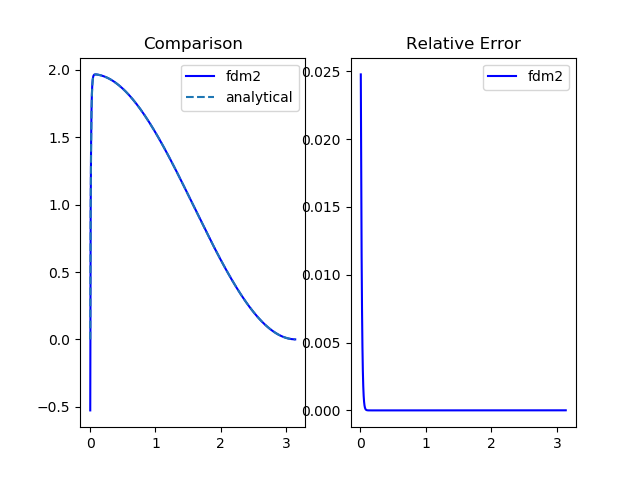

In [9]:
%matplotlib notebook

#plotting and comparing the results

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(x, u, label = "fdm2", c = 'b')
ax1.plot(x, u_analytical(x), label = "analytical", ls = '--')
ax1.legend()
ax1.set_title("Comparison")

ax2.plot(x[1:N+1], np.abs((u[1:N+1]-u_analytical(x[1:N+1]))/u_analytical(x[1:N+1])), c = 'b', label = 'fdm2')
ax2.set_title('Relative Error')
ax2.legend()

In [8]:
#Check the accuracy for different k



kk = np.linspace(0, 0.1, 100)

#Calculating the max absolute error for the given step size
error_abs_max1 = np.zeros(len(kk))                                     
for n in range(len(kk) -1):
    
    xx, dxdx = nonuniform_grid(x_l, x_r, N, kk[n])
    error_abs_max1[n] = np.max(np.abs(general_bvp_mixed(xx, dxdx, source(xx, deriv_coef), 
                                                        boundary_conditions, 
                                                        deriv_coef, 'fdm2') - u_analytical(xx)))

#Plotting the results    
fig, ax = plt.subplots()
ax.plot(kk, error_abs_max1, c = 'b', label = 'fdm2')
ax.legend()

SystemExit: code doesn't work for mixed boundary conditions and a non-uniform grid yet

/home/petros/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
